IMPORT LIBRARY YANG DIPERLUKAN UNTUK PEMODELAN SARIMA

In [1]:
#KONFIGURASI MACHINE

#library untuk manipulasi data
import pandas as pd
import numpy as np

#library untuk visualisasi 
import matplotlib.pyplot as plt
import seaborn as sns

#library untuk analisis time series
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

#library untuk pemodelan SARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller 
import statsmodels.api as sm
from sklearn.model_selection import ParameterGrid
from math import sqrt
from scipy import stats
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

#library untuk pemodelan Holt-Winter
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#library untuk evaluasi model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#library untuk mengabaikan peringatan
import warnings
warnings.filterwarnings("ignore")

#library untuk menyimpan model
import pickle

In [2]:
dataset = pd.read_excel("dataset.xlsx")

In [3]:
dataset.head(10)

,tanggal,volume_produksi
0,2001-01-01,3.698909
1,2001-01-02,4.079162
2,2001-01-03,3.548420
3,2001-01-04,2.874586
4,2001-01-05,1.071931
5,2001-01-06,0.995154
6,2001-01-07,1.609147
7,2001-01-08,1.754739
8,2001-01-09,1.647734
9,2001-01-10,0.466489


In [4]:
# Bulatkan kolom volume produksi menjadi angka desimal dengan dua angka di belakang koma
dataset['volume_produksi'] = dataset['volume_produksi'].round(2)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8216 entries, 0 to 8215
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tanggal          8216 non-null   datetime64[ns]
 1   volume_produksi  8216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.5 KB


DATA PREPARATION

In [6]:
# Pengecekan format tanggal
dataset['tanggal'] = pd.to_datetime(dataset['tanggal'], format='%Y-%m-%d')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8216 entries, 0 to 8215
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tanggal          8216 non-null   datetime64[ns]
 1   volume_produksi  8216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.5 KB


In [7]:
# Identifikasi missing values
missing_values = dataset.isnull().sum()

# Mengisi missing values dengan mean
dataset['volume_produksi'].fillna(dataset['volume_produksi'].mean(), inplace=True)

In [8]:
# Mengatur kolom 'tanggal' sebagai index
dataset['tanggal'] = pd.to_datetime(dataset['tanggal'])  # Pastikan kolom tanggal dalam format datetime
dataset.set_index('tanggal', inplace=True)

# Resample data harian ke bulanan dan hitung rata-rata bulanan
monthly_data = dataset.resample('M').mean()

In [9]:
monthly_data.head()

,volume_produksi
tanggal,
2001-01-31,2.138065
2001-02-28,1.915000
2001-03-31,2.155484
2001-04-30,1.881333
2001-05-31,2.133226


In [10]:
year_data=dataset.resample('Y').mean()

In [11]:
monthly_data

,volume_produksi
tanggal,
2001-01-31,2.138065
2001-02-28,1.915000
2001-03-31,2.155484
2001-04-30,1.881333
2001-05-31,2.133226
...,...
2023-02-28,2.065714
2023-03-31,1.931290
2023-04-30,2.076333


In [12]:
# Bulatkan kolom volume produksi menjadi angka desimal dengan dua angka di belakang koma
monthly_data['volume_produksi'] = monthly_data['volume_produksi'].round(2)

In [13]:
monthly_data

,volume_produksi
tanggal,
2001-01-31,2.14
2001-02-28,1.91
2001-03-31,2.16
2001-04-30,1.88
2001-05-31,2.13
...,...
2023-02-28,2.07
2023-03-31,1.93
2023-04-30,2.08


In [14]:
len(monthly_data) 

270

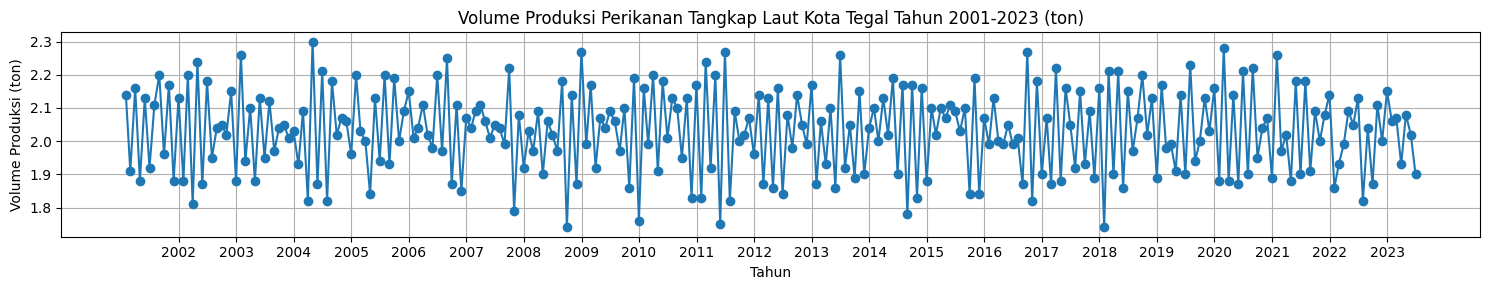

In [15]:
# Membuat plot dari data bulanan
plt.figure(figsize=(15, 3))
plt.plot(monthly_data.index, monthly_data['volume_produksi'], marker='o')

# Menentukan interval tahun pada sumbu x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Menampilkan setiap tahun pada sumbu x
plt.xticks(pd.date_range(start=monthly_data.index.min(), end=monthly_data.index.max(), freq='YS'))

plt.title('Volume Produksi Perikanan Tangkap Laut Kota Tegal Tahun 2001-2023 (ton)')
plt.xlabel('Tahun')
plt.ylabel('Volume Produksi (ton)')
plt.grid(True)
plt.tight_layout()
plt.show()

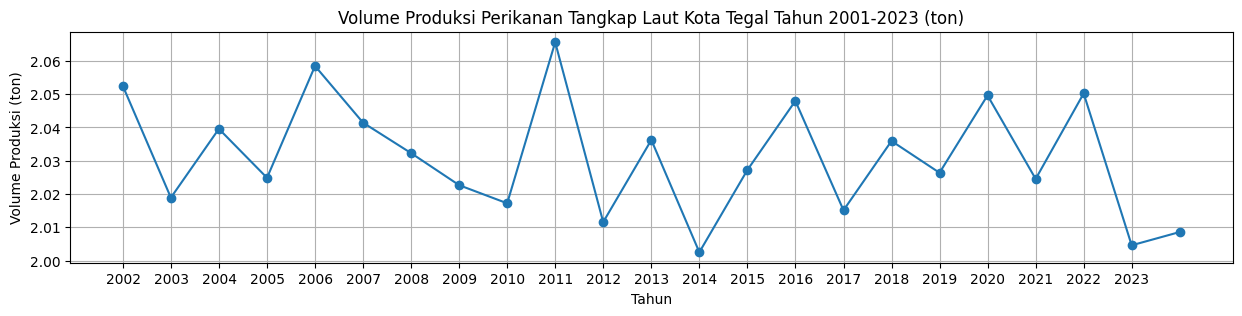

In [16]:
# Membuat plot dari data bulanan
plt.figure(figsize=(15,3))
plt.plot(year_data.index, year_data['volume_produksi'], marker='o')

# Menentukan interval tahun pada sumbu x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Menampilkan setiap tahun pada sumbu x
plt.xticks(pd.date_range(start=monthly_data.index.min(), end=monthly_data.index.max(), freq='YS'))

plt.title('Volume Produksi Perikanan Tangkap Laut Kota Tegal Tahun 2001-2023 (ton)')
plt.xlabel('Tahun')
plt.ylabel('Volume Produksi (ton)')
plt.grid(True)
plt.show()

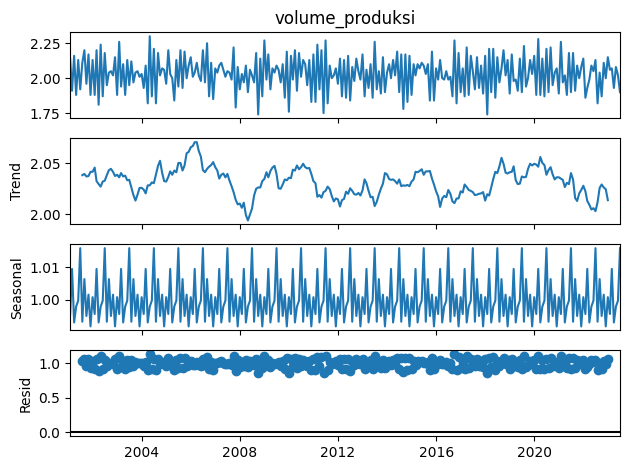

In [17]:
# Lakukan dekomposisi musiman
hasil_dekomposisi= seasonal_decompose(monthly_data['volume_produksi'], model='multiplicative', period=12)
# Plot hasil dekomposisi
hasil_dekomposisi.plot()
plt.show()

In [18]:
# Melakukan uji ADF
result = adfuller(monthly_data)

# Menampilkan hasil
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretasi hasil berdasarkan nilai kritis 5%
adf_statistic = result[0]
critical_value_5percent = result[4]['5%']

print(f'\n==== HASIL UJI ADF ====')
print(f'\nADF Statistic: {adf_statistic}')
print(f'Critical Value (Nilai Kritis) (5%): {critical_value_5percent}')

if adf_statistic < critical_value_5percent:
    print('Menolak Hipotesis null (H0) - Data Stasioner')
else:
    print('Gagal Menolak Hipotesis null (H0) - Data Tidak Stasioner')

ADF Statistic: -4.591092920482864
p-value: 0.00013414159630597346
Critical Values:
   1%: -3.4560535712549925
   5%: -2.8728527662442334
   10%: -2.5727985212493754

==== HASIL UJI ADF ====

ADF Statistic: -4.591092920482864
Critical Value (Nilai Kritis) (5%): -2.8728527662442334
Menolak Hipotesis null (H0) - Data Stasioner


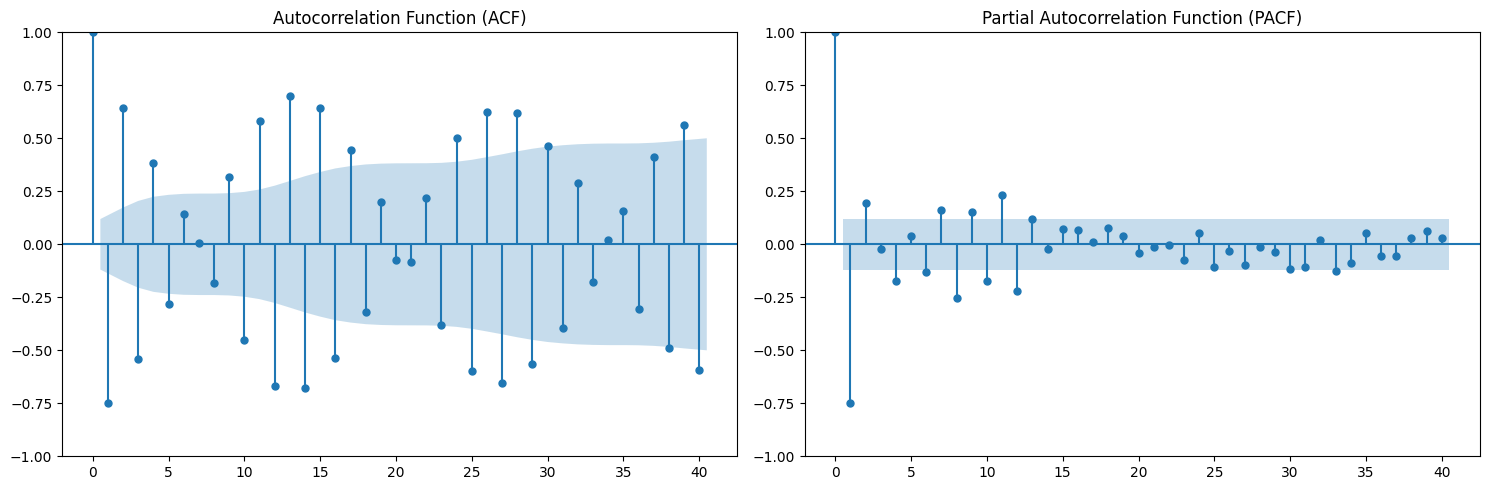

In [19]:
# Membuat plot ACF
plt.figure(figsize=(15, 5))

plt.subplot(121)
plot_acf(monthly_data, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

# Membuat plot PACF
plt.subplot(122)
plot_pacf(monthly_data, ax=plt.gca(), lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

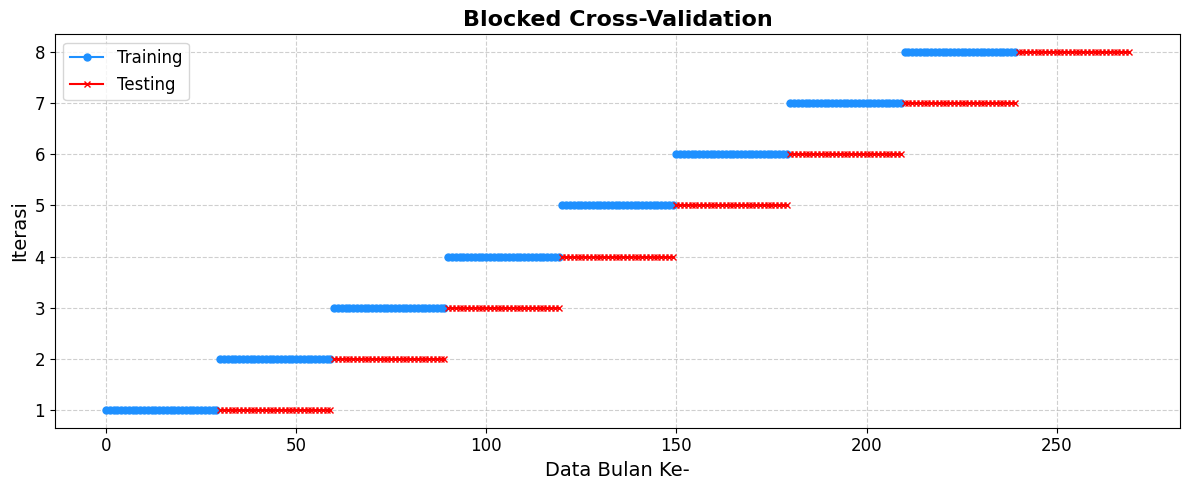

In [20]:
# VISUALISASI UNTUK MENGGAMBARKAN BLOCKED CROSS VALIDATION

# Total jumlah data
total_data = 270

# Panjang setiap blok pelatihan dan pengujian
train_size = 30
test_size = 30

# Menghitung jumlah iterasi blocked cross-validation
num_iterations = (total_data - train_size) // test_size

# Membuat grafik blocked cross-validation
plt.figure(figsize=(12, 5))

# Warna untuk data training dan testing
train_color = 'dodgerblue'
test_color = 'red'

for i in range(num_iterations):
    # Indeks awal dan akhir dari data pelatihan dan pengujian
    train_start = i * test_size
    train_end = train_start + train_size
    test_start = train_end
    test_end = test_start + test_size
    
    # Plot data pelatihan
    plt.plot(np.arange(train_start, train_end), np.ones(train_end - train_start) + i, 
             color=train_color, linestyle='-', marker='o', markersize=5, label='Training' if i == 0 else "")
    # Plot data pengujian
    plt.plot(np.arange(test_start, test_end), np.ones(test_end - test_start) + i, 
             color=test_color, linestyle='-', marker='x', markersize=5, label='Testing' if i == 0 else "")

# Menambahkan elemen grafis
plt.xlabel('Data Bulan Ke-', fontsize=14)
plt.ylabel('Iterasi', fontsize=14)
plt.title('Blocked Cross-Validation', fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

GRID SEARCH BLOCKED CROSS VALIDATION SARIMA

In [21]:
# Parameter untuk grid search yang lebih luas
p = q = range(0, 4)
d = range(0, 3)
P = Q = range(0, 4)
D = range(0, 3)
s = 12  # Seasonal period untuk data bulanan dengan seasonality tahunan

# Ukuran training dan testing
train_size = 30
test_size = 30

# Fungsi untuk melakukan evaluasi SARIMA
def evaluate_sarima(train_data, test_data, order, seasonal_order):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    return mse, model_fit, predictions


# Melakukan blocked cross-validation dengan grid search
results = []
best_mse = float('inf')
best_model_fit = None
all_models = []


for i in range(0, len(monthly_data), test_size):
    start_train = i
    end_train = start_train + train_size
    start_test = end_train
    end_test = start_test + test_size

    if end_test > len(monthly_data):  # Memastikan tidak melebihi batas data
        break

    train_data = monthly_data.iloc[start_train:end_train]
    test_data = monthly_data.iloc[start_test:end_test]

    local_best_mse = float('inf')
    local_best_order = None
    local_best_seasonal_order = None
    local_best_model_fit = None
    local_best_predictions = None

    for p_ in p:
        for d_ in d:
            for q_ in q:
                for P_ in P:
                    for D_ in D:
                        for Q_ in Q:
                            order = (p_, d_, q_)
                            seasonal_order = (P_, D_, Q_, s)
                            try:
                                mse, model_fit, predictions = evaluate_sarima(train_data['volume_produksi'], test_data['volume_produksi'], order, seasonal_order)
                                if mse < local_best_mse:
                                    local_best_mse = mse
                                    local_best_order = order
                                    local_best_seasonal_order = seasonal_order
                                    local_best_model_fit = model_fit
                                    local_best_predictions = predictions
                            except Exception as e:
                                continue

    all_models.append((train_data, test_data, local_best_order, local_best_seasonal_order, local_best_model_fit, local_best_predictions))
    results.append((i // test_size + 1, start_train, end_train, start_test, end_test, local_best_order, local_best_seasonal_order, local_best_mse))

# Menampilkan hasil
for result in results:
    iteration, start_train, end_train, start_test, end_test, best_order, best_seasonal_order, best_mse = result
    print(f"Iteration {iteration}: Train=(Month {start_train + 1}-{end_train}), Test=(Month {start_test + 1}-{end_test}), SARIMA{best_order}x{best_seasonal_order} MSE={best_mse:.3f}")

# Menentukan iterasi terbaik berdasarkan MSE
best_iteration = min(results, key=lambda x: x[-1])
print(f"\nBest Iteration: Train=(Month {best_iteration[1] + 1}-{best_iteration[2]}), Test=(Month {best_iteration[3] + 1}-{best_iteration[4]}), SARIMA{best_iteration[5]}x{best_iteration[6]} MSE={best_iteration[7]:.3f}")

Iteration 1: Train=(Month 1-30), Test=(Month 31-60), SARIMA(2, 1, 3)x(0, 0, 0, 12) MSE=0.006
Iteration 2: Train=(Month 31-60), Test=(Month 61-90), SARIMA(3, 1, 1)x(0, 0, 1, 12) MSE=0.008
Iteration 3: Train=(Month 61-90), Test=(Month 91-120), SARIMA(2, 1, 3)x(2, 0, 0, 12) MSE=0.008
Iteration 4: Train=(Month 91-120), Test=(Month 121-150), SARIMA(2, 1, 2)x(0, 0, 0, 12) MSE=0.005
Iteration 5: Train=(Month 121-150), Test=(Month 151-180), SARIMA(3, 1, 3)x(0, 0, 1, 12) MSE=0.003
Iteration 6: Train=(Month 151-180), Test=(Month 181-210), SARIMA(0, 1, 1)x(2, 0, 1, 12) MSE=0.013
Iteration 7: Train=(Month 181-210), Test=(Month 211-240), SARIMA(2, 1, 3)x(0, 0, 0, 12) MSE=0.007
Iteration 8: Train=(Month 211-240), Test=(Month 241-270), SARIMA(3, 1, 0)x(1, 0, 1, 12) MSE=0.007

Best Iteration: Train=(Month 121-150), Test=(Month 151-180), SARIMA(3, 1, 3)x(0, 0, 1, 12) MSE=0.003


VISUALISASI MASING-MASING ITERASI

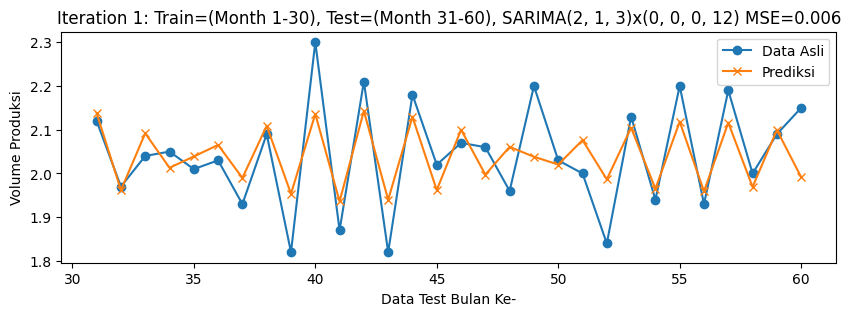

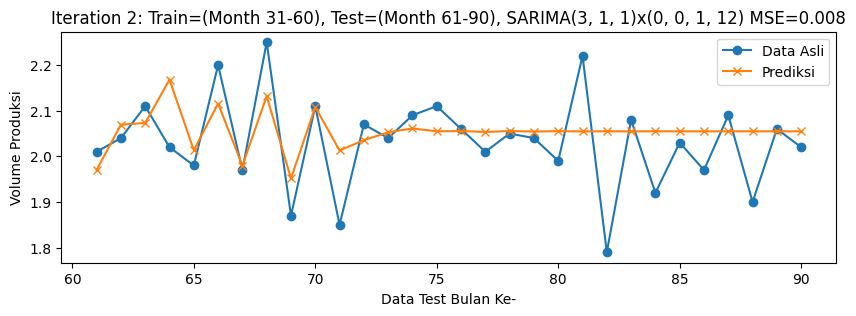

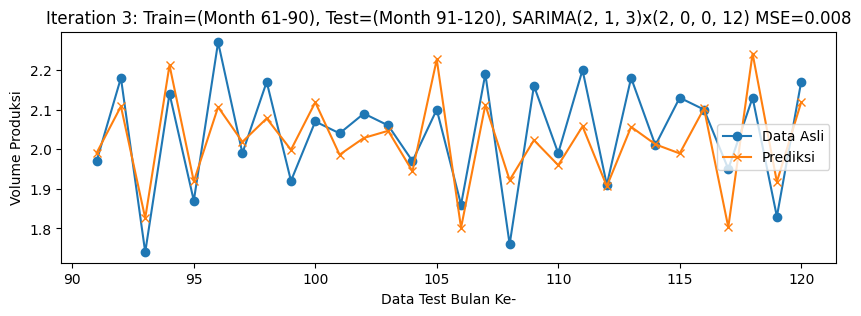

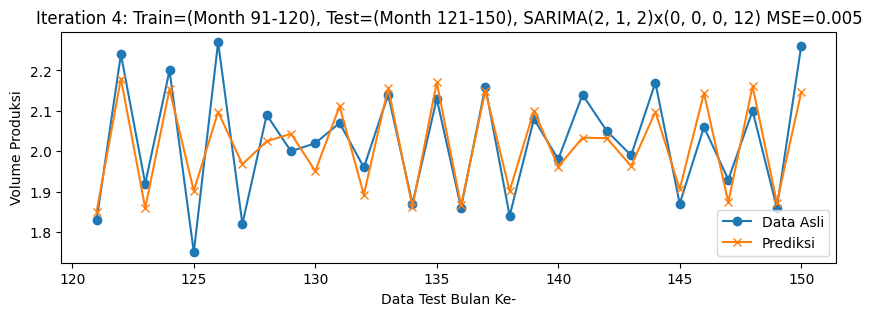

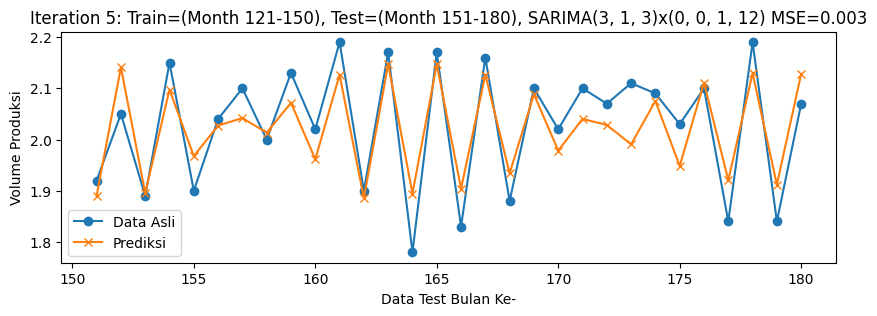

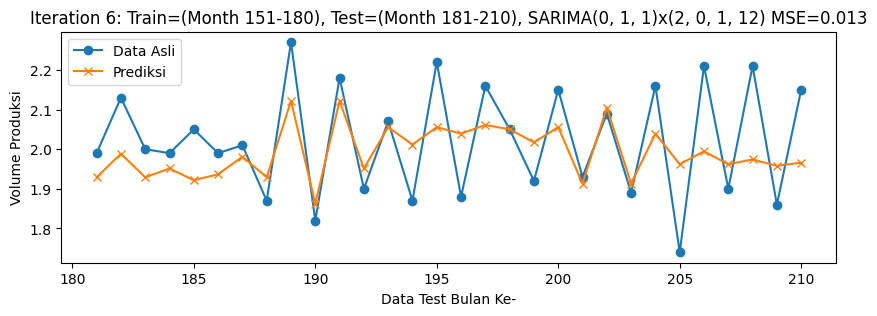

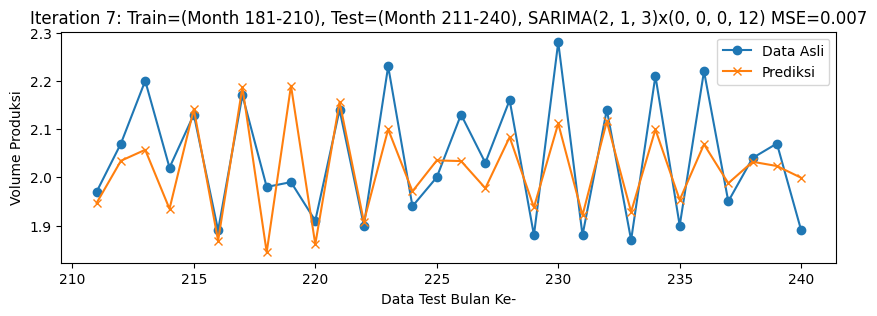

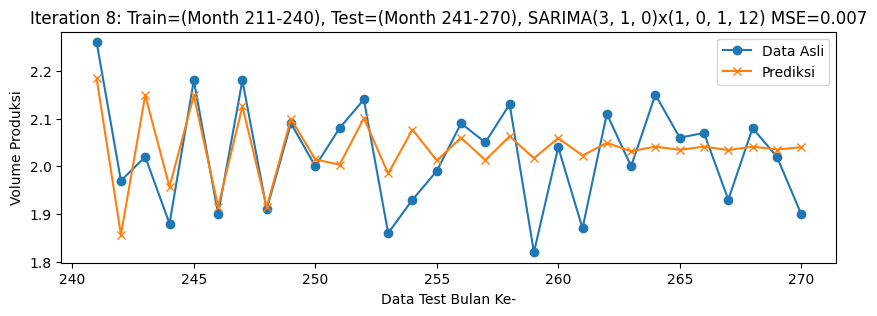

In [22]:
import matplotlib.pyplot as plt

# Visualisasi hasil prediksi vs data asli untuk masing-masing iterasi
for result in results:
    iteration, start_train, end_train, start_test, end_test, best_order, best_seasonal_order, best_mse = result
    train_data, test_data, _, _, _, predictions = all_models[iteration - 1]

    # Generate X values as the actual month number in the entire dataset
    x_values = range(start_test + 1, end_test + 1)
    
    plt.figure(figsize=(10, 3))
    plt.plot(x_values, test_data['volume_produksi'], label='Data Asli', marker='o')
    plt.plot(x_values, predictions, label='Prediksi',marker='x')
    plt.xlabel('Data Test Bulan Ke-')
    plt.ylabel('Volume Produksi')
    plt.title(f"Iteration {iteration}: Train=(Month {start_train + 1}-{end_train}), Test=(Month {start_test + 1}-{end_test}), SARIMA{best_order}x{best_seasonal_order} MSE={best_mse:.3f}")
    plt.legend()
    plt.show()


VISUALIASI BEST MODEL SARIMA

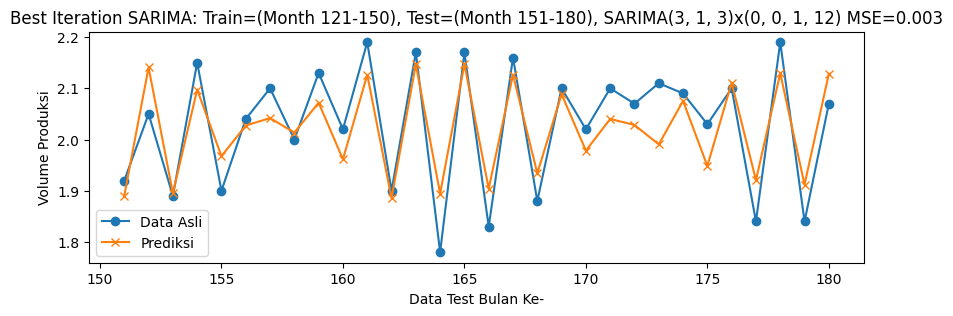

            Month  Actual  Predicted
2013-07-31    151    1.92   1.890549
2013-08-31    152    2.05   2.140891
2013-09-30    153    1.89   1.895241
2013-10-31    154    2.15   2.097438
2013-11-30    155    1.90   1.967668
2013-12-31    156    2.04   2.027315
2014-01-31    157    2.10   2.041947
2014-02-28    158    2.00   2.013551
2014-03-31    159    2.13   2.071811
2014-04-30    160    2.02   1.961385
2014-05-31    161    2.19   2.126499
2014-06-30    162    1.90   1.885287
2014-07-31    163    2.17   2.146974
2014-08-31    164    1.78   1.894357
2014-09-30    165    2.17   2.146880
2014-10-31    166    1.83   1.904170
2014-11-30    167    2.16   2.126481
2014-12-31    168    1.88   1.934149
2015-01-31    169    2.10   2.088451
2015-02-28    170    2.02   1.978361
2015-03-31    171    2.10   2.040168
2015-04-30    172    2.07   2.028464
2015-05-31    173    2.11   1.990536
2015-06-30    174    2.09   2.075404
2015-07-31    175    2.03   1.948345
2015-08-31    176    2.10   2.111042
2

In [40]:
# Mendapatkan iterasi terbaik berdasarkan MSE terendah
best_iteration = min(results, key=lambda x: x[-1])
best_iter_num, best_start_train, best_end_train, best_start_test, best_end_test, best_order, best_seasonal_order, best_mse = best_iteration

# Mengambil data dan model terbaik dari iterasi terbaik
_, best_test_data, _, _, best_model_fit, _ = all_models[best_iter_num - 1]

# Generate X values as the actual month number in the entire dataset
x_values = range(best_start_test + 1, best_end_test + 1)

# Membuat prediksi menggunakan model terbaik
best_predictions = best_model_fit.forecast(steps=len(best_test_data))

# Membuat DataFrame baru untuk perbandingan data asli dengan hasil prediksi
comparison_df = pd.DataFrame({
    'Month': x_values,
    'Actual': best_test_data['volume_produksi'].values,
    'Predicted': best_predictions
})

# Visualisasi data test dan prediksi untuk model terbaik
plt.figure(figsize=(10, 3))
plt.plot(comparison_df['Month'], comparison_df['Actual'], label='Data Asli', marker='o')
plt.plot(comparison_df['Month'], comparison_df['Predicted'], label='Prediksi', marker='x')
plt.xlabel('Data Test Bulan Ke-')
plt.ylabel('Volume Produksi')
plt.title(f"Best Iteration SARIMA: Train=(Month {best_start_train + 1}-{best_end_train}), Test=(Month {best_start_test + 1}-{best_end_test}), SARIMA{best_order}x{best_seasonal_order} MSE={best_mse:.3f}")
plt.legend()
plt.show()

# Menampilkan DataFrame perbandingan
print(comparison_df)


EVALUASI MODEL TERBAIK SARIMA

In [41]:
# Mengambil data aktual untuk perbandingan
actual = best_test_data['volume_produksi']

# Menghitung Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, best_predictions)

# Menghitung Mean Squared Error (MSE)
mse = mean_squared_error(actual, best_predictions)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Menghitung Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual - best_predictions) / actual)) * 100

# Menampilkan hasil evaluasi
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")

MAE: 0.050
MSE: 0.003
RMSE: 0.058
MAPE: 2.497%


PREDIKSI 3 TAHUN KEDEPAN (48 BULAN) MENGGUNAKAN MODEL SARIMA TERBAIK

In [25]:
monthly_data.index.min(), monthly_data.index.max()

(Timestamp('2001-01-31 00:00:00'), Timestamp('2023-06-30 00:00:00'))

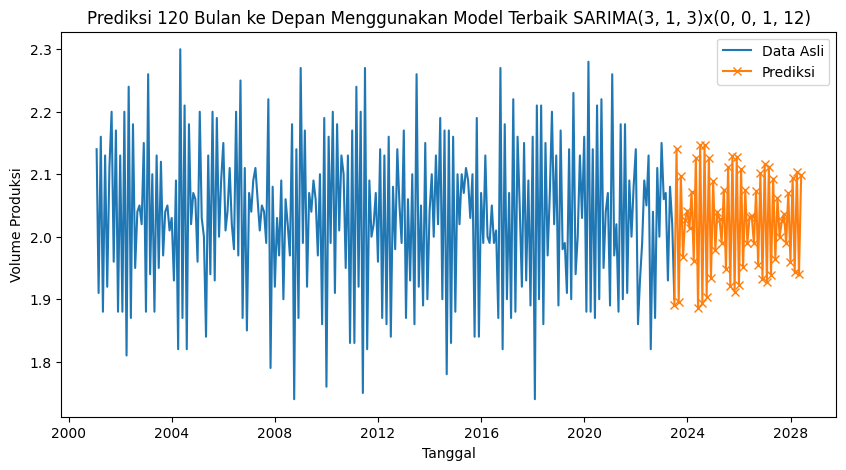

In [36]:
# Menentukan tanggal mulai prediksi
start_date = '2023-06-30'

# Menghitung jumlah langkah prediksi (10 tahun ke depan, dalam bulan)
steps = 5 * 12

# Membuat prediksi menggunakan model terbaik
future_predictions = best_model_fit.forecast(steps=steps)

# Membuat rangkaian tanggal untuk prediksi
future_dates = pd.date_range(start=start_date, periods=steps, freq='M')

# Membuat DataFrame untuk hasil prediksi
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Volume': future_predictions
})

# Visualisasi prediksi 10 tahun ke depan
plt.figure(figsize=(10, 5))
plt.plot(monthly_data.index, monthly_data['volume_produksi'], label='Data Asli')
plt.plot(predictions_df['Date'], predictions_df['Predicted Volume'], label='Prediksi', marker='x')
plt.xlabel('Tanggal')
plt.ylabel('Volume Produksi')
plt.title(f"Prediksi 120 Bulan ke Depan Menggunakan Model Terbaik SARIMA{best_order}x{best_seasonal_order}")
plt.legend()
plt.show()

In [38]:
print(predictions_df)

                 Date  Predicted Volume
2013-07-31 2023-06-30          1.890549
2013-08-31 2023-07-31          2.140891
2013-09-30 2023-08-31          1.895241
2013-10-31 2023-09-30          2.097438
2013-11-30 2023-10-31          1.967668
2013-12-31 2023-11-30          2.027315
2014-01-31 2023-12-31          2.041947
2014-02-28 2024-01-31          2.013551
2014-03-31 2024-02-29          2.071811
2014-04-30 2024-03-31          1.961385
2014-05-31 2024-04-30          2.126499
2014-06-30 2024-05-31          1.885287
2014-07-31 2024-06-30          2.146974
2014-08-31 2024-07-31          1.894357
2014-09-30 2024-08-31          2.146880
2014-10-31 2024-09-30          1.904170
2014-11-30 2024-10-31          2.126481
2014-12-31 2024-11-30          1.934149
2015-01-31 2024-12-31          2.088451
2015-02-28 2025-01-31          1.978361
2015-03-31 2025-02-28          2.040168
2015-04-30 2025-03-31          2.028464
2015-05-31 2025-04-30          1.990536
2015-06-30 2025-05-31          2.075404


SIMPAN MODEL TERBAIK MENGGUNAKAN PICKLE

In [37]:
# Simpan model terbaik menggunakan pickle
with open('best_sarima_model.pkl', 'wb') as pkl_file:
    pickle.dump(best_model_fit, pkl_file)

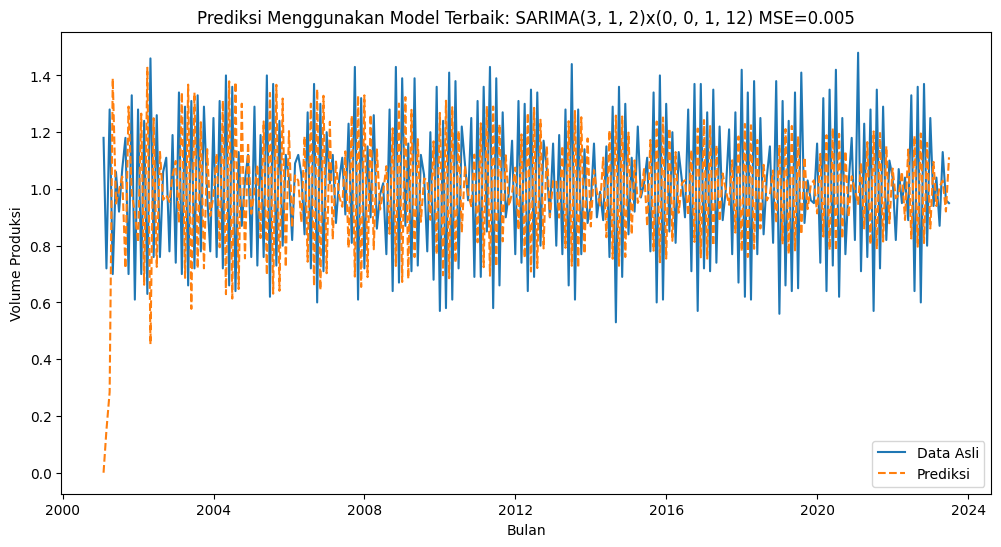

In [22]:
# Membuat prediksi sepanjang data asli
predictions = best_model_fit.predict(start=0, end=len(monthly_data) - 1)

# Visualisasi data asli dan prediksi
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['volume_produksi'], label='Data Asli')
plt.plot(monthly_data.index, predictions, label='Prediksi', linestyle='--')
plt.xlabel('Bulan')
plt.ylabel('Volume Produksi')
plt.title(f"Prediksi Menggunakan Model Terbaik: SARIMA{best_order}x{best_seasonal_order} MSE={best_mse:.3f}")
plt.legend()
plt.show()

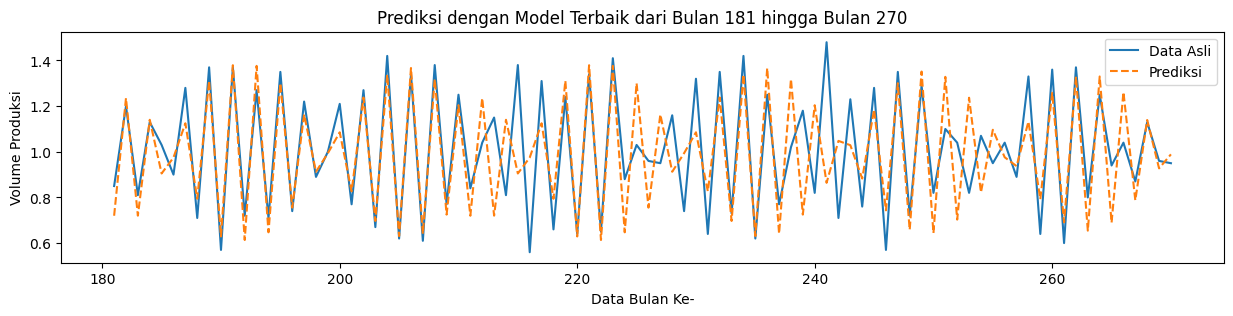

In [23]:
# Prediksi dengan model terbaik untuk data validasi hingga data ke-270
validation_start = best_end_test
validation_end = 270

# Membuat prediksi untuk periode validasi
predictions_val = best_model_fit.get_forecast(steps=(validation_end - validation_start)).predicted_mean

# Menggabungkan data test dan prediksi validasi
combined_data = pd.concat([best_test_data, monthly_data.iloc[validation_start:validation_end]], ignore_index=True)
combined_predictions = np.concatenate([best_model_fit.forecast(steps=len(best_test_data)), predictions_val])

# Generate X values as the actual month number in the entire dataset
x_values = range(best_start_test + 1, validation_end + 1)

# Visualisasi data asli dan prediksi untuk periode validasi
plt.figure(figsize=(15, 3))
plt.plot(x_values, combined_data['volume_produksi'], label='Data Asli')
plt.plot(x_values, combined_predictions, label='Prediksi', linestyle='--')
plt.xlabel('Data Bulan Ke-')
plt.ylabel('Volume Produksi')
plt.title(f"Prediksi dengan Model Terbaik dari Bulan {best_start_test + 1} hingga Bulan {validation_end}")
plt.legend()
plt.show()

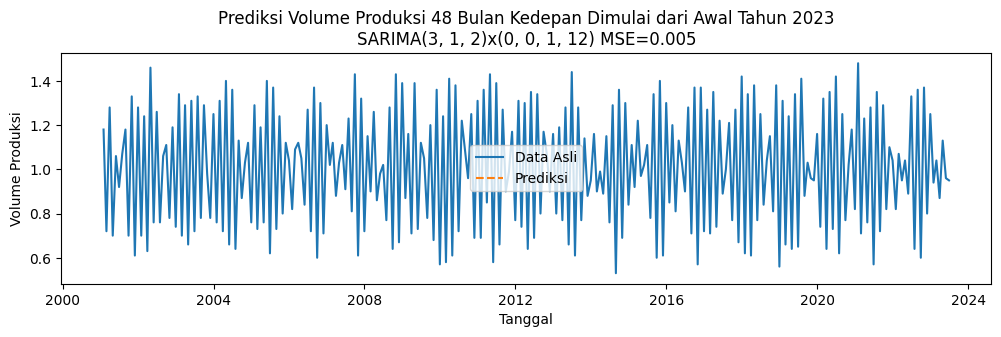

In [24]:

# Assume monthly_data has a DateTimeIndex
monthly_data.index = pd.to_datetime(monthly_data.index)

# Menentukan periode prediksi
forecast_steps = 48

# Mengambil indeks tahun 2023
start_forecast_period = pd.Timestamp('2023-01-01')


# Membuat prediksi selama 48 bulan ke depan mulai dari awal tahun 2023
future_predictions = best_model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Menggabungkan data asli hingga akhir tahun 2022 dengan prediksi
full_range = pd.date_range(start=start_forecast_period, periods=forecast_steps, freq='M')
predicted_data = pd.Series(future_predictions, index=full_range)

# Plot data asli hingga akhir tahun 2022 dan prediksi selama 48 bulan ke depan
plt.figure(figsize=(12, 3))
plt.plot(monthly_data.index, monthly_data['volume_produksi'], label='Data Asli')
plt.plot(predicted_data.index, predicted_data, label='Prediksi', linestyle='--')
plt.xlabel('Tanggal')
plt.ylabel('Volume Produksi')
plt.title(f'Prediksi Volume Produksi 48 Bulan Kedepan Dimulai dari Awal Tahun 2023\nSARIMA{best_order}x{best_seasonal_order} MSE={best_mse:.3f}')
plt.legend()
plt.show()


EVALUASI UNTUK PREDIKSI 3 TAHUN KEDEPAN